# Data preprocessing

In [1]:
# Imports
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt

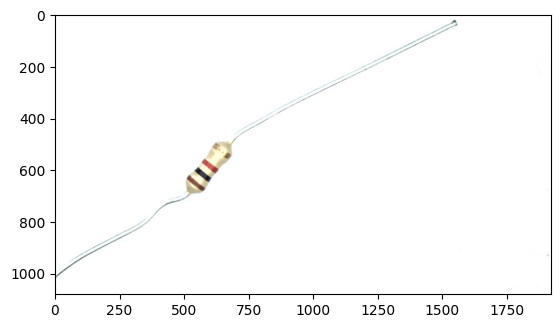

In [2]:
# Get all image path names
path_names = glob.glob('../data/resistor_images/*jpg')

# Select image
image = cv2.imread(path_names[0])

# Label
label = path_names[0].split('_')[-1][0:3]

# Show image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

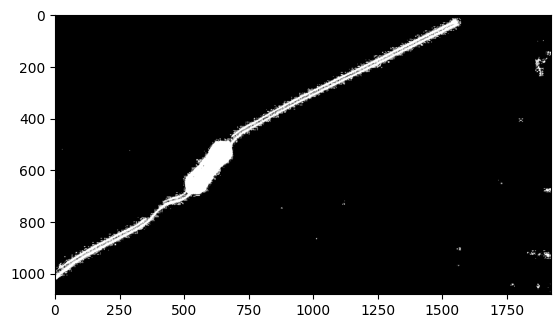

In [3]:
# Convert to gray to threshold background
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Threshold background
_, threshed = cv2.threshold(image_gray, 254, 255, cv2.THRESH_BINARY_INV)

# Show threshed mask
plt.imshow(threshed, cmap='gray')
plt.show()

To remove the sticks, we use some morphological transformations. 

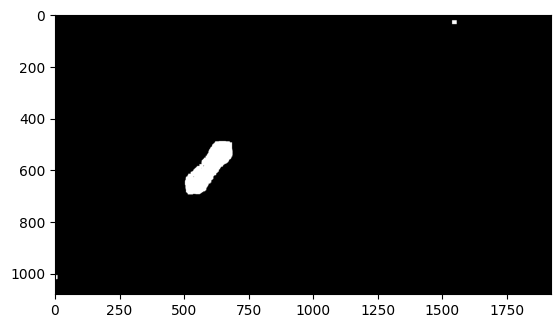

In [4]:
# The kernel is chosen to be larger than the sticks, and smaller than the resistor
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))

# We open the image in order to remove the sticks
morphed_open = cv2.morphologyEx(threshed, cv2.MORPH_OPEN, kernel)

# Show opened mask
plt.imshow(morphed_open, cmap='gray')
plt.show()

We want to find the bounding box of the resistor. Using the binary mask, we find the contour of the resistor and obtain its bounding box. 

C:\Users\matth\AppData\Local\Temp\ipykernel_12240\938441542.py:15: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  debug_image = cv2.drawContours(image.copy(),[np.int0(cv2.boxPoints(rect))], 0, (0,0,255), 2)


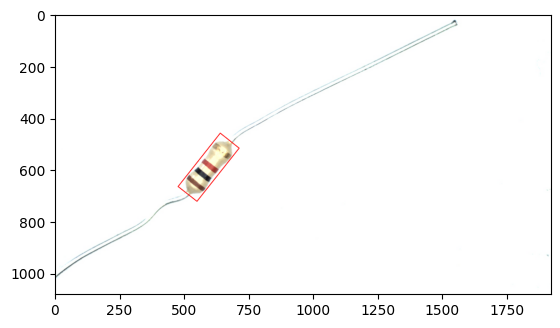

In [5]:
# Find contour of resistor
contours = cv2.findContours(morphed_open, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]

# Filter contours
#contours = list(filter(lambda x: (cv2.contourArea(x) < 20000), contours)) 
#contours = list(filter(lambda x: (cv2.contourArea(x) > 5000), contours)) 

# Get largest contour
maxcontour = max(contours, key=cv2.contourArea)

# Get minimal area rectangle
rect = cv2.minAreaRect(maxcontour)

# Draw bounding box
debug_image = cv2.drawContours(image.copy(),[np.int0(cv2.boxPoints(rect))], 0, (0,0,255), 2)

# Show bounding box
plt.imshow(cv2.cvtColor(debug_image, cv2.COLOR_BGR2RGB), cmap='gray')
plt.show()

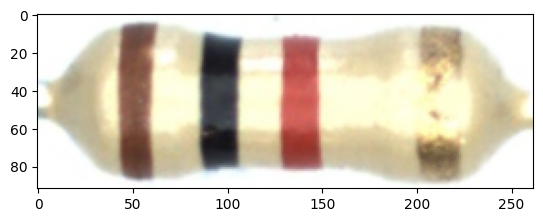

In [6]:
# Get rectangle properties
angle = rect[2]
rows, cols = image.shape[0], image.shape[1]

# Rotate image
M = cv2.getRotationMatrix2D((rect[0][0],rect[0][1]), angle-90, 1)
image_aligned = cv2.warpAffine(image,M,(cols,rows))

# Rotate bounding box 
box = cv2.boxPoints((rect[0], rect[1], angle))
pts = np.intp(cv2.transform(np.array([box]), M))[0]    
pts[pts < 0] = 0

# Cropping
image_cropped = image_aligned[pts[0][1]:pts[3][1], pts[0][0]:pts[2][0]]

# Show cropped image
plt.imshow(cv2.cvtColor(image_cropped, cv2.COLOR_BGR2RGB), cmap='gray')
plt.show()


Next, we will detect the color bands using a combination of two thresholding masks. 

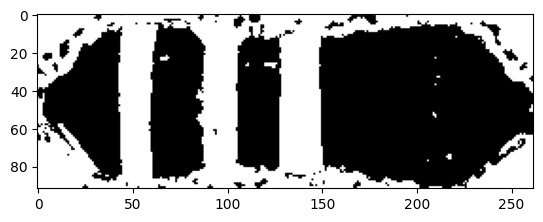

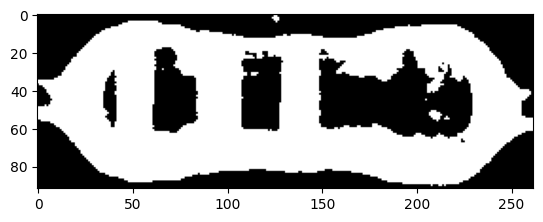

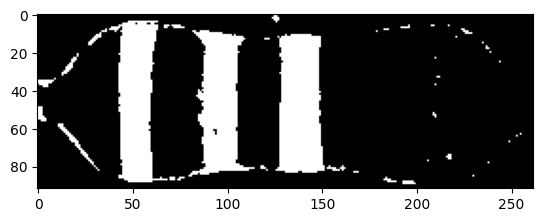

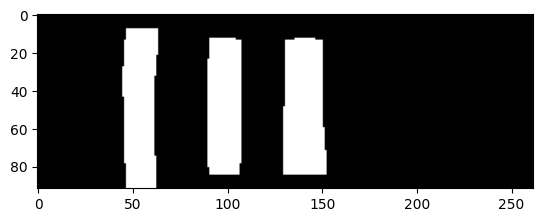

In [7]:
# Get HSV calibration params 
hsvfile1 = np.load('../data/demo3_hsv_resistor.npy')
hsvfile2 = np.load('../data/demo3_hsv_background.npy')

# Convert image to HSV to simplify thresholding
hsv = cv2.cvtColor(image_cropped, cv2.COLOR_BGR2HSV)

# Remove area in between color bands
mask1 = cv2.bitwise_not(cv2.inRange(hsv, np.array([hsvfile1[0], hsvfile1[2], hsvfile1[4]]), np.array([hsvfile1[1], hsvfile1[3], hsvfile1[5]])))

# Show mask 1
plt.imshow(mask1, cmap='gray')
plt.show()

# Remove background
mask2 = cv2.inRange(hsv, np.array([hsvfile2[0], hsvfile2[2], hsvfile2[4]]), np.array([hsvfile2[1], hsvfile2[3], hsvfile2[5]]))

# Show mask 2
plt.imshow(mask2, cmap='gray')
plt.show()

# Combine effects
mask = cv2.bitwise_and(mask1, mask2)

# Show cropped image
plt.imshow(mask, cmap='gray')
plt.show()

# Morphological transformations to remove sticks
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))
morphed_open = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
mask = cv2.morphologyEx(morphed_open, cv2.MORPH_CLOSE, kernel)

# Show cropped image
plt.imshow(mask, cmap='gray')
plt.show()

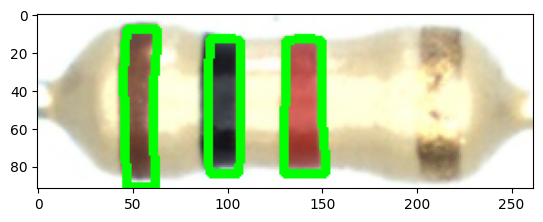

In [8]:
# Find the three largest contours of the color bands
contours = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]

# Get three largest contours
largest_contours = sorted(contours, key=cv2.contourArea, reverse=True)[0:3]

# Sort contours from left to right
sorted_contours = sorted(largest_contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

# Plot
image_cropped = cv2.drawContours(image_cropped.copy(), sorted_contours, -1, (0,255,0), 3)

# Show cropped image
plt.imshow(cv2.cvtColor(image_cropped, cv2.COLOR_BGR2RGB))
plt.show()

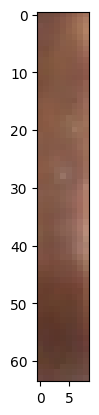

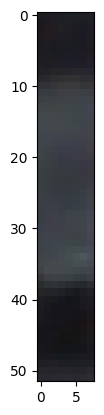

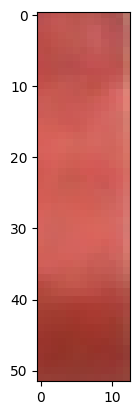

In [9]:
# Iterate over the three contours
color_bands = []
for ctr in sorted_contours:

    # Get roi
    x,y,w,h = cv2.boundingRect(ctr)
    roi_rgb = image_cropped[y+10:y+h-10, x+5:x+w-5]
    roi_hsv = hsv[y+10:y+h-10, x+5:x+w-5]

    # Show cropped image
    plt.imshow(cv2.cvtColor(roi_rgb, cv2.COLOR_BGR2RGB))
    plt.show()

    # Get hsv
    roi_h = [i for i in roi_hsv[:,:,0].ravel() if i != 0]  
    roi_s = [i for i in roi_hsv[:,:,1].ravel() if i != 0]  
    roi_v = [i for i in roi_hsv[:,:,2].ravel() if i != 0]  

    # Get means of HSV data
    mean_hsv = [np.mean(roi_h), np.mean(roi_s), np.mean(roi_v)]

    # Add to data
    color_bands.append(mean_hsv)

[[8.359375, 118.14756944444444, 127.21006944444444], [115.1256038647343, 38.64251207729468, 54.21634615384615], [2.9509954058192958, 152.59467455621302, 191.13757396449705]]


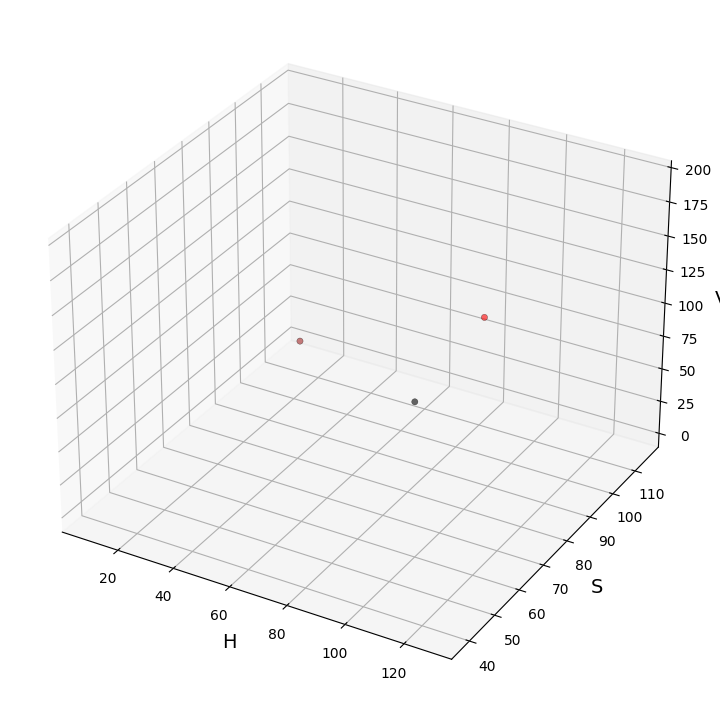

In [10]:
# Create empty dataset
print(color_bands)

# Plot
colors = {'x':'gray','r':'red','z':'brown','k':'black','b':'blue','v':'magenta','g':'green'}
c = list(map(lambda x: colors[str(x)], list(label)))
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(color_bands[:][0], color_bands[:][1], color_bands[:][2], c=c, alpha=.6, edgecolor='k', lw=0.3)
ax.set_xlabel('H', fontsize=14)
ax.set_ylabel('S', fontsize=14)
ax.set_zlabel('V', fontsize=14)
plt.show()